In [81]:
!pip install  flaml openfe optuna  -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv('./df_train2.csv')
df_t = pd.read_csv('./df_test2.csv')

In [3]:
def feature_engineering(df,df_test,target,n_jobs=4):
    from openfe import OpenFE, transform
    train_x,test_x,train_y,n_jobs = df.drop(target,axis=1),df_test,df[target],n_jobs
    ofe = OpenFE()
    features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features
    train_x, test_x = transform(train_x, test_x, features, n_jobs=n_jobs) # transform the train and test data according to generated features.
    return train_x, test_x

def ag_tuning(df_train,df_test,id_name='0620',label='Survived',loss='log_loss',presets='best_quality',dynamic_stacking=True,folds=10,time=60*3):
    from autogluon.tabular import TabularPredictor
    from autogluon.features.generators import AutoMLPipelineFeatureGenerator
    auto_ml_pipeline_feature_generator = AutoMLPipelineFeatureGenerator()
    from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
    
    custom_hyperparameters = get_hyperparameter_config('default')
    
    def get_oof_ts(predictor,_train_x,_test_x,ids,label):
        predictions_oof = predictor.predict_oof()
        prdict_y = predictor.predict(_test_x)
        pd.DataFrame({'oofs': predictions_oof, 'predict_y': prdict_y}).to_csv(f'model_hc_systhis_{ids}.csv',index=False)
        _train_x[ids],_test_x[ids]  = predictions_oof,prdict_y
        _train_x.to_csv(f'model_hc_tr_{ids}.csv',index=False)
        _test_x.to_csv(f'model_hc_ts_{ids}.csv',index=False)
        return predictions_oof,prdict_y
    
    predictor = TabularPredictor(
        label=label,
        # problem_type=problem,#'binary',
        eval_metric=loss #'acc'
    ).fit(
        df_train, #df, #df_train,
        presets='best_quality',
    #     unlabeled_data = df_test2,   #df_test2.drop(columns='Survived'), #df_train[800:].drop(columns='Survived'),
        # auto_stack=True,
        feature_generator=auto_ml_pipeline_feature_generator,
        ag_args_ensemble = {'fold_fitting_strategy':'sequential_local'},
        dynamic_stacking=dynamic_stacking,
    #     num_stack_levels=1,
        num_bag_folds=folds,
        # time_limit=time,
        # included_model_types = ['XGB','NN_TORCH','CATBOOST','LIGHTGBM','FAST_AI'],
    #     excluded_model_types = ['NN_TORCH'],
        # use_bag_holdout=True,
        # hyperparameters=custom_hyperparameters,
        hyperparameter_tune_kwargs='auto',#hyperparameter_tune_kwargs,
        # keep_only_best = True,
    )
    oofs,predictions = get_oof_ts(predictor,df_train,df_test,id_name,label)
    return predictions,oofs,predictor
# show_info(predictor,train_x)

def show_info(predictor,df_train):
    print('++++++++++++++++++++++++++++++++++++++++++++++')
    print(predictor.fit_summary())
    print('++++++++++++++++++++++++++++++++++++++++++++++')
    print(predictor.leaderboard(df_train,silent=True))
    print('++++++++++++++++++++++++++++++++++++++++++++++')
    print(predictor.feature_importance(df_train,silent=True))
    print('++++++++++++++++++++++++++++++++++++++++++++++')

from sklearn.metrics import mean_squared_error,roc_auc_score
def hill_climbers(files,train_path,test_path,label='Survived',func=roc_auc_score):
    from hillclimbers import climb_hill, partial
    
    train,test = pd.read_csv(train_path),pd.read_csv(test_path)
    oofs,pred = pd.DataFrame(),pd.DataFrame()
    for i in range(len(files)):
        tmp = pd.read_csv(files[i])
        oofs[f'm{i}'],pred[f'm{i}'] = tmp['oofs'].dropna(),tmp['predict_y'].dropna()

    test_preds, oof_preds = climb_hill(
        train=train, 
        oof_pred_df=oofs, 
        test_pred_df=pred,
        target=label,
        objective="maximize",
        eval_metric=partial(func),
        negative_weights=True, 
        precision=0.001,
        plot_hill=True, 
        plot_hist=True,
        return_oof_preds=True
    )
    return test_preds, oof_preds
# a,b = hill_climbers(files,train_path,test_path=test_path,label='Survived')

def titanic_acc(predictions):
    from sklearn.metrics import accuracy_score
    acc= pd.read_csv('./acc.csv')
    acc_ans = acc.Survived
    print(accuracy_score(acc_ans,predictions)) 

def submission(predictions,test_x,cols,label,id_name):
    test_x[label] = predictions
    test_x[cols].to_csv(f'submission_{id_name}.csv',index=False)
    
    
def pipline(df1,df1_test,label='Survived',time=60*3,id_name='0620_v3',loss='log_loss',cols=['1','2']):
    # train_x, test_x = feature_engineering(df1,df1_test,label)
    # train_x[label] = df1[label]
    # train_x.to_csv('tr.csv',index=False)
    # test_x.to_csv('ts.csv',index=False)
    train_x,test_x = df1,df1_test
    predictions,oofs,predictor = ag_tuning(train_x,test_x,id_name=id_name,time=time,loss=loss,label=label)
    show_info(predictor,train_x)
    # titanic_acc(predictions)
    submission(predictions,test_x,cols,label,id_name)
    return predictions


In [29]:
fe

In [36]:
def get_feather(train_x,train_y,n_jobs=4):
    from openfe import OpenFE
    ofe = OpenFE()
    return ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features


def feature_engineering(df,df_test,target,n_jobs=4,features=[]):
    from openfe import transform
    train_x,test_x,train_y,n_jobs = df.drop(target,axis=1),df_test,df[target],n_jobs
    if features == []:
        fe = get_feather(train_x,train_y,n_jobs)
    else:
        fe = features
    print(fe)
    train_x, test_x = transform(train_x, test_x, fe, n_jobs=n_jobs) # transform the train and test data according to generated features.
    return train_x, test_x,fe
train_x, test_x,fe = feature_engineering(df,df_t,'Target',features=fe)
train_x

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,autoFE_f_0
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2.804398
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,2.804398
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,6.019190
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,2.804398
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,2.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,1,17,1,9254,1,1,121.0,1,19,1,...,0,6,8,5,10.600000,0,13.9,-0.3,0.79,5.073755
76514,1,1,6,9254,1,1,125.0,1,1,38,...,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,2.374457
76515,5,17,1,9085,1,1,138.0,1,37,37,...,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,2.374457
76516,1,1,3,9070,1,1,136.0,1,38,37,...,0,6,0,0,0.000000,0,7.6,2.6,0.32,2.253893


In [37]:
test_x

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,autoFE_f_0
0,1,1,1,9500,1,1,141.0,1,3,1,...,0,8,0,0,0.000000,0,13.9,-0.3,0.79,5.073755
1,1,1,1,9238,1,1,128.0,1,1,19,...,0,6,6,6,13.500000,0,11.1,0.6,2.02,2.804398
2,1,1,1,9238,1,1,118.0,1,1,19,...,0,6,11,5,11.000000,0,15.5,2.8,-4.06,5.287255
3,1,44,1,9147,1,39,130.0,1,1,19,...,3,8,14,5,11.000000,0,8.9,1.4,3.51,4.329636
4,1,39,1,9670,1,1,110.0,1,1,37,...,0,6,9,4,10.666667,2,7.6,2.6,0.32,2.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,1,1,2,171,1,1,128.0,1,38,37,...,0,0,0,0,0.000000,0,15.5,2.8,-4.06,5.287255
51008,2,39,1,9119,1,19,133.1,1,19,37,...,0,5,5,0,0.000000,0,9.4,-0.8,-3.12,2.374457
51009,1,1,1,171,1,1,127.0,1,1,1,...,0,0,0,0,0.000000,0,15.5,2.8,-4.06,5.287255
51010,1,1,3,9773,1,1,132.0,1,19,19,...,0,6,9,3,13.000000,0,7.6,2.6,0.32,2.253893


In [38]:
import numpy as np
def transform(df):
    features = df.columns.tolist()
    sorted_new =  np.sort(df.values, axis=1)
    # df['mean_features'] = 0.1 * df[features].mean(axis=1)
    # df['std_features'] = df[features].std(axis=1)
    # df['max_features'] = df[features].max(axis=1)
    # df['min_features'] = df[features].min(axis=1)
    # df['median_features'] = 0.1 * df[features].median(axis=1)
    # df['sum_features'] = 0.1 * df[features].sum(axis=1)

    num_cols = features
    df['sum'] = df[num_cols].sum(axis=1)*0.1
    df['std']  = df[num_cols].std(axis=1)
    df['mean'] = df[num_cols].mean(axis=1)*0.1
    df['max']  = df[num_cols].max(axis=1)
    df['min']  = df[num_cols].min(axis=1)
    # df['mode'] = df[num_cols].mode(axis=1)[0]*0.1
    df['median'] = df[num_cols].median(axis=1)*0.1
    df['q_25th'] = df[num_cols].quantile(0.25, axis=1)*0.1
    df['q_75th'] = df[num_cols].quantile(0.75, axis=1)*0.1
    df['skew'] = df[num_cols].skew(axis=1)
    df['kurt'] = df[num_cols].kurt(axis=1)
    df['sum_72_76'] = df['sum'].isin(np.arange(72, 76))
    for i in range(20,100,10):
        df[f'{i}th'] = df[num_cols].quantile(i/100, axis=1)
    # df['harmonic'] = len(num_cols) / df[num_cols].apply(lambda x: (1/x).mean(), axis=1)
    # df['geometric'] = df[num_cols].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    # df['zscore'] = df[num_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
    df['cv'] = df['std'] / df['mean']
    df['Skewness_75'] = (df[num_cols].quantile(0.75, axis=1) - df[num_cols].mean(axis=1)) / df[num_cols].std(axis=1)
    df['Skewness_25'] = (df[num_cols].quantile(0.25, axis=1) - df[num_cols].mean(axis=1)) / df[num_cols].std(axis=1)
    # df['2ndMoment'] = df[num_cols].apply(lambda x: (x**2).mean(), axis=1)
    # df['3rdMoment'] = df[num_cols].apply(lambda x: (x**3).mean(), axis=1)
    # df['entropy'] = df[num_cols].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    # # df1 = pd.concat([df, pd.DataFrame(sorted_new, index=df.index)], axis=1)
    # # df1 = df1.drop(features, axis=1)
    # # df1.columns = df1.columns.astype('str')
    return df

df_train = transform(train_x)#df.drop(['Target'],axis=1))
df_test = transform(test_x) #df_t.drop([],axis=1))


In [39]:
# df_cp = df_train.combine_first(df)
# df_cp
df_train['Target'] = df['Target'] 
df_train

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,40th,50th,60th,70th,80th,90th,cv,Skewness_75,Skewness_25,Target
0,1,1,1,9238,1,1,126.0,1,1,19,...,1.000,1.000000,5.000000,6.00,10.280000,18.4,58.336032,-0.167466,-0.171025,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,1.000,1.000000,5.200000,9.00,11.500000,19.0,58.218264,-0.165835,-0.171767,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0.000,1.000000,1.000000,3.00,6.015352,18.4,58.341669,-0.167457,-0.171404,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,1.000,2.020000,3.000000,7.20,11.080000,18.4,58.287248,-0.165796,-0.170923,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,1.000,2.253893,6.000000,7.88,12.746667,26.2,58.089664,-0.164456,-0.171943,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,1,17,1,9254,1,1,121.0,1,19,1,...,1.000,1.000000,5.629502,7.20,10.653333,18.4,58.288369,-0.165639,-0.171041,Graduate
76514,1,1,6,9254,1,1,125.0,1,1,38,...,1.000,1.000000,5.200000,6.60,12.280000,28.4,58.072779,-0.166275,-0.172198,Graduate
76515,5,17,1,9085,1,1,138.0,1,37,37,...,1.000,4.000000,5.000000,9.52,12.900000,37.0,57.726456,-0.165588,-0.172560,Enrolled
76516,1,1,3,9070,1,1,136.0,1,38,37,...,0.128,1.000000,1.000000,3.40,7.280000,37.4,58.182719,-0.167844,-0.171872,Dropout


In [40]:
df_test

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,30th,40th,50th,60th,70th,80th,90th,cv,Skewness_75,Skewness_25
0,1,1,1,9500,1,1,141.0,1,3,1,...,0.00,0.00,0.790000,1.000000,1.200000,4.659004,15.54,58.554993,-0.168857,-0.170780
1,1,1,1,9238,1,1,128.0,1,1,19,...,0.92,1.00,1.000000,4.600000,6.000000,10.280000,19.00,58.358658,-0.167400,-0.171354
2,1,1,1,9238,1,1,118.0,1,1,19,...,1.00,1.00,1.000000,5.172353,6.600000,11.000000,18.40,58.374263,-0.164058,-0.171308
3,1,44,1,9147,1,39,130.0,1,1,19,...,1.00,1.64,3.000000,5.000000,9.320000,14.800000,41.00,57.619487,-0.165895,-0.172887
4,1,39,1,9670,1,1,110.0,1,1,37,...,1.00,1.00,2.253893,4.600000,6.320000,10.333333,37.80,58.295431,-0.165873,-0.170910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,1,1,2,171,1,1,128.0,1,38,37,...,0.00,0.00,1.000000,1.000000,2.160000,9.400000,37.40,25.962291,-0.251390,-0.385174
51008,2,39,1,9119,1,19,133.1,1,19,37,...,0.00,0.40,1.000000,3.949783,6.600000,17.080000,37.80,57.751804,-0.167144,-0.173155
51009,1,1,1,171,1,1,127.0,1,1,1,...,0.00,0.00,0.000000,1.000000,1.000000,3.760000,17.30,29.915795,-0.308554,-0.334272
51010,1,1,3,9773,1,1,132.0,1,19,19,...,1.00,1.00,2.600000,5.000000,6.320000,11.880000,19.00,58.321985,-0.166478,-0.171263


In [6]:
# df_test_cp  = df_test.combine_first(df_t)
# df_test_cp

,Admission grade,Age at enrollment,Application mode,Application order,Course,Curricular units 1st sem (approved),Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (grade),...,Previous qualification (grade),Scholarship holder,Tuition fees up to date,Unemployment rate,max_features,mean_features,median_features,min_features,std_features,sum_features
0,152.1,18,1,1,9500,0,0,7,0,0.000000,...,141.0,0,0,13.9,9500.0,27.376361,0.0395,-0.30,1582.002355,985.549000
1,116.5,19,1,1,9238,6,0,6,7,14.857143,...,128.0,0,1,11.1,9238.0,26.712714,0.1000,0.00,1538.118351,961.657714
2,114.2,18,1,1,9238,6,0,6,11,12.000000,...,118.0,1,1,15.5,9238.0,26.698444,0.1000,-4.06,1538.117590,961.144000
3,130.0,23,44,1,9147,5,2,6,15,11.500000,...,130.0,1,1,8.9,9147.0,26.775861,0.3000,0.00,1522.457632,963.931000
4,106.0,26,39,1,9670,3,0,6,9,11.000000,...,110.0,0,1,7.6,9670.0,27.992185,0.2300,0.00,1609.929880,1007.718667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,124.7,19,1,2,171,0,0,0,0,0.000000,...,128.0,0,1,15.5,171.0,1.549833,0.0500,-4.06,40.045161,55.794000
51008,140.0,33,39,1,9119,0,0,5,6,0.000000,...,133.1,0,0,9.4,9119.0,26.640500,0.1000,-3.12,1517.926969,959.058000
51009,120.4,20,1,1,171,0,0,0,0,0.000000,...,127.0,0,0,15.5,171.0,1.321222,0.0000,-4.06,39.414092,47.564000
51010,126.3,18,1,3,9773,5,0,6,8,12.600000,...,132.0,0,0,7.6,9773.0,28.278944,0.2800,0.00,1627.160057,1018.042000


In [35]:
X_train.to_csv('aa.csv',index=False)

In [41]:
# X_train, y_train = df_cp.drop('Target',axis=1),df_cp['Target']
X_train, y_train = df_train.drop('Target',axis=1),df_train['Target']

In [44]:
from flaml.default import LGBMRegressor

estimator = LGBMRegressor()
(
    hyperparams,
    estimator_name,
    X_transformed,
    y_transformed,
) = estimator.suggest_hyperparams(X_train, y_train)
print(hyperparams)

{'n_estimators': 4797, 'num_leaves': 122, 'min_child_samples': 2, 'learning_rate': 0.022635758411078528, 'colsample_bytree': 0.7019911744574896, 'reg_alpha': 0.004252223402511765, 'reg_lambda': 0.11288241427227624, 'max_bin': 511, 'verbose': -1}


In [ ]:
estimator.fit()

In [53]:
automl2.save_best_config('./aa.json')

In [75]:
import os

num_cpus = os.cpu_count()
print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 8


In [79]:
from flaml import ray
ray.init(num_cpus=16)

ImportError: cannot import name 'ray' from 'flaml' (/opt/anaconda3/envs/mykaggle/lib/python3.9/site-packages/flaml/__init__.py)

In [87]:
# from flaml import AutoML
from sklearn.linear_model import LogisticRegression

automl2 = AutoML()
automl_settings = {
    "task": "classification",
    "starting_points": "data",
    "estimator_list": ["lgbm","catboost","xgboost"],
    "time_budget": None,
    "max_iter": 2,
    "early_stop":True,
    "starting_points":automl.best_config_per_estimator,
    # 'n_concurrent_trials':2,
    # 'n_jobs':2,
    "ensemble": {
        "final_estimator": LogisticRegression(),
        "passthrough": False,
    },
}
automl2.fit(X_train, y_train, **automl_settings)

[flaml.automl.logger: 06-24 19:58:42] {1680} INFO - task = classification
[flaml.automl.logger: 06-24 19:58:42] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-24 19:58:42] {1789} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 06-24 19:58:42] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'catboost', 'xgboost']
[flaml.automl.logger: 06-24 19:58:42] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-24 20:11:12] {2345} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 06-24 20:11:12] {2392} INFO -  at 751.0s,	estimator lgbm's best error=0.4371,	best estimator lgbm's best error=0.4371
[flaml.automl.logger: 06-24 20:11:12] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-24 20:21:20] {2392} INFO -  at 1359.0s,	estimator lgbm's best error=0.4371,	best estimator lgbm's best error=0.4371
[flaml.automl.logger: 06-24 20:21:20] {2526} INFO - [('lgbm', {'

In [60]:


automl_settings = {
    "task": "classification",
    "starting_points": "data",
    "estimator_list": ["lgbm",'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1'],
    "time_budget": 10000,
    "early_stop":True,
    # "max_iter": 2,
    "log_file_name": "./acadamic.log",
}
automl = AutoML()
automl.fit(X_train, y_train, **automl_settings)


[flaml.automl.logger: 06-24 15:22:12] {1680} INFO - task = classification
[flaml.automl.logger: 06-24 15:22:12] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-24 15:22:12] {1789} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 06-24 15:22:12] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-24 15:22:12] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-24 15:44:41] {2345} INFO - Estimated sufficient time budget=13496250s. Estimated necessary time budget=331333s.
[flaml.automl.logger: 06-24 15:44:41] {2392} INFO -  at 1350.5s,	estimator lgbm's best error=0.4371,	best estimator lgbm's best error=0.4371
[flaml.automl.logger: 06-24 15:44:41] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-24 16:02:11] {2392} INFO -  at 2400.3s,	estimator lgbm's best error=0.4371,	best estimator lgbm's best error=0.4371
[flaml.aut

In [66]:
automl.save_best_config('./0624v1.json')

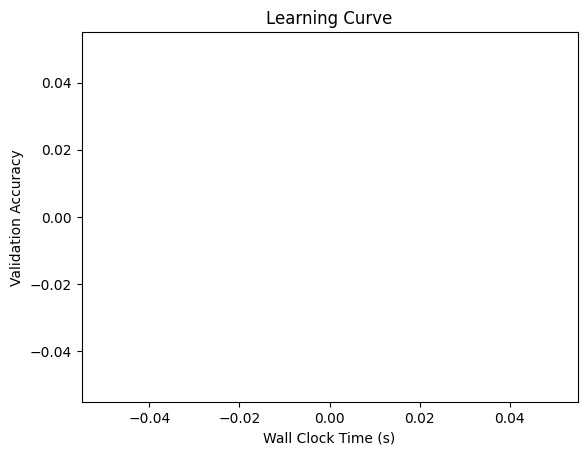

In [70]:
from flaml.automl.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename='./acadamic.log', time_budget=120)
import matplotlib.pyplot as plt
import numpy as np

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()

In [73]:
import pickle
with open("./model/automl_83767.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [61]:
# pd = automl.predict(df_test_cp)
pd = automl.predict(df_test)

In [62]:
import pandas

In [14]:
df_test_cp

,Admission grade,Age at enrollment,Application mode,Application order,Course,Curricular units 1st sem (approved),Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (grade),...,Previous qualification (grade),Scholarship holder,Tuition fees up to date,Unemployment rate,max_features,mean_features,median_features,min_features,std_features,sum_features
0,152.1,18,1,1,9500,0,0,7,0,0.000000,...,141.0,0,0,13.9,9500.0,27.376361,0.0395,-0.30,1582.002355,985.549000
1,116.5,19,1,1,9238,6,0,6,7,14.857143,...,128.0,0,1,11.1,9238.0,26.712714,0.1000,0.00,1538.118351,961.657714
2,114.2,18,1,1,9238,6,0,6,11,12.000000,...,118.0,1,1,15.5,9238.0,26.698444,0.1000,-4.06,1538.117590,961.144000
3,130.0,23,44,1,9147,5,2,6,15,11.500000,...,130.0,1,1,8.9,9147.0,26.775861,0.3000,0.00,1522.457632,963.931000
4,106.0,26,39,1,9670,3,0,6,9,11.000000,...,110.0,0,1,7.6,9670.0,27.992185,0.2300,0.00,1609.929880,1007.718667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,124.7,19,1,2,171,0,0,0,0,0.000000,...,128.0,0,1,15.5,171.0,1.549833,0.0500,-4.06,40.045161,55.794000
51008,140.0,33,39,1,9119,0,0,5,6,0.000000,...,133.1,0,0,9.4,9119.0,26.640500,0.1000,-3.12,1517.926969,959.058000
51009,120.4,20,1,1,171,0,0,0,0,0.000000,...,127.0,0,0,15.5,171.0,1.321222,0.0000,-4.06,39.414092,47.564000
51010,126.3,18,1,3,9773,5,0,6,8,12.600000,...,132.0,0,0,7.6,9773.0,28.278944,0.2800,0.00,1627.160057,1018.042000


In [63]:
def submission(predictions,test_x,cols,label,id_name):
    test_x[label] = predictions
    test_x[cols].to_csv(f'submission_{id_name}.csv',index=False)
test = pandas.read_csv('df_test.csv')
submission(pd,test,['id','Target'],'Target','academic_0624_v2_flaml')

In [64]:
!kaggle competitions submit -c playground-series-s4e6 -f submission_academic_0624_v2_flaml.csv -m "Message"

zsh:1: command not found: kaggle


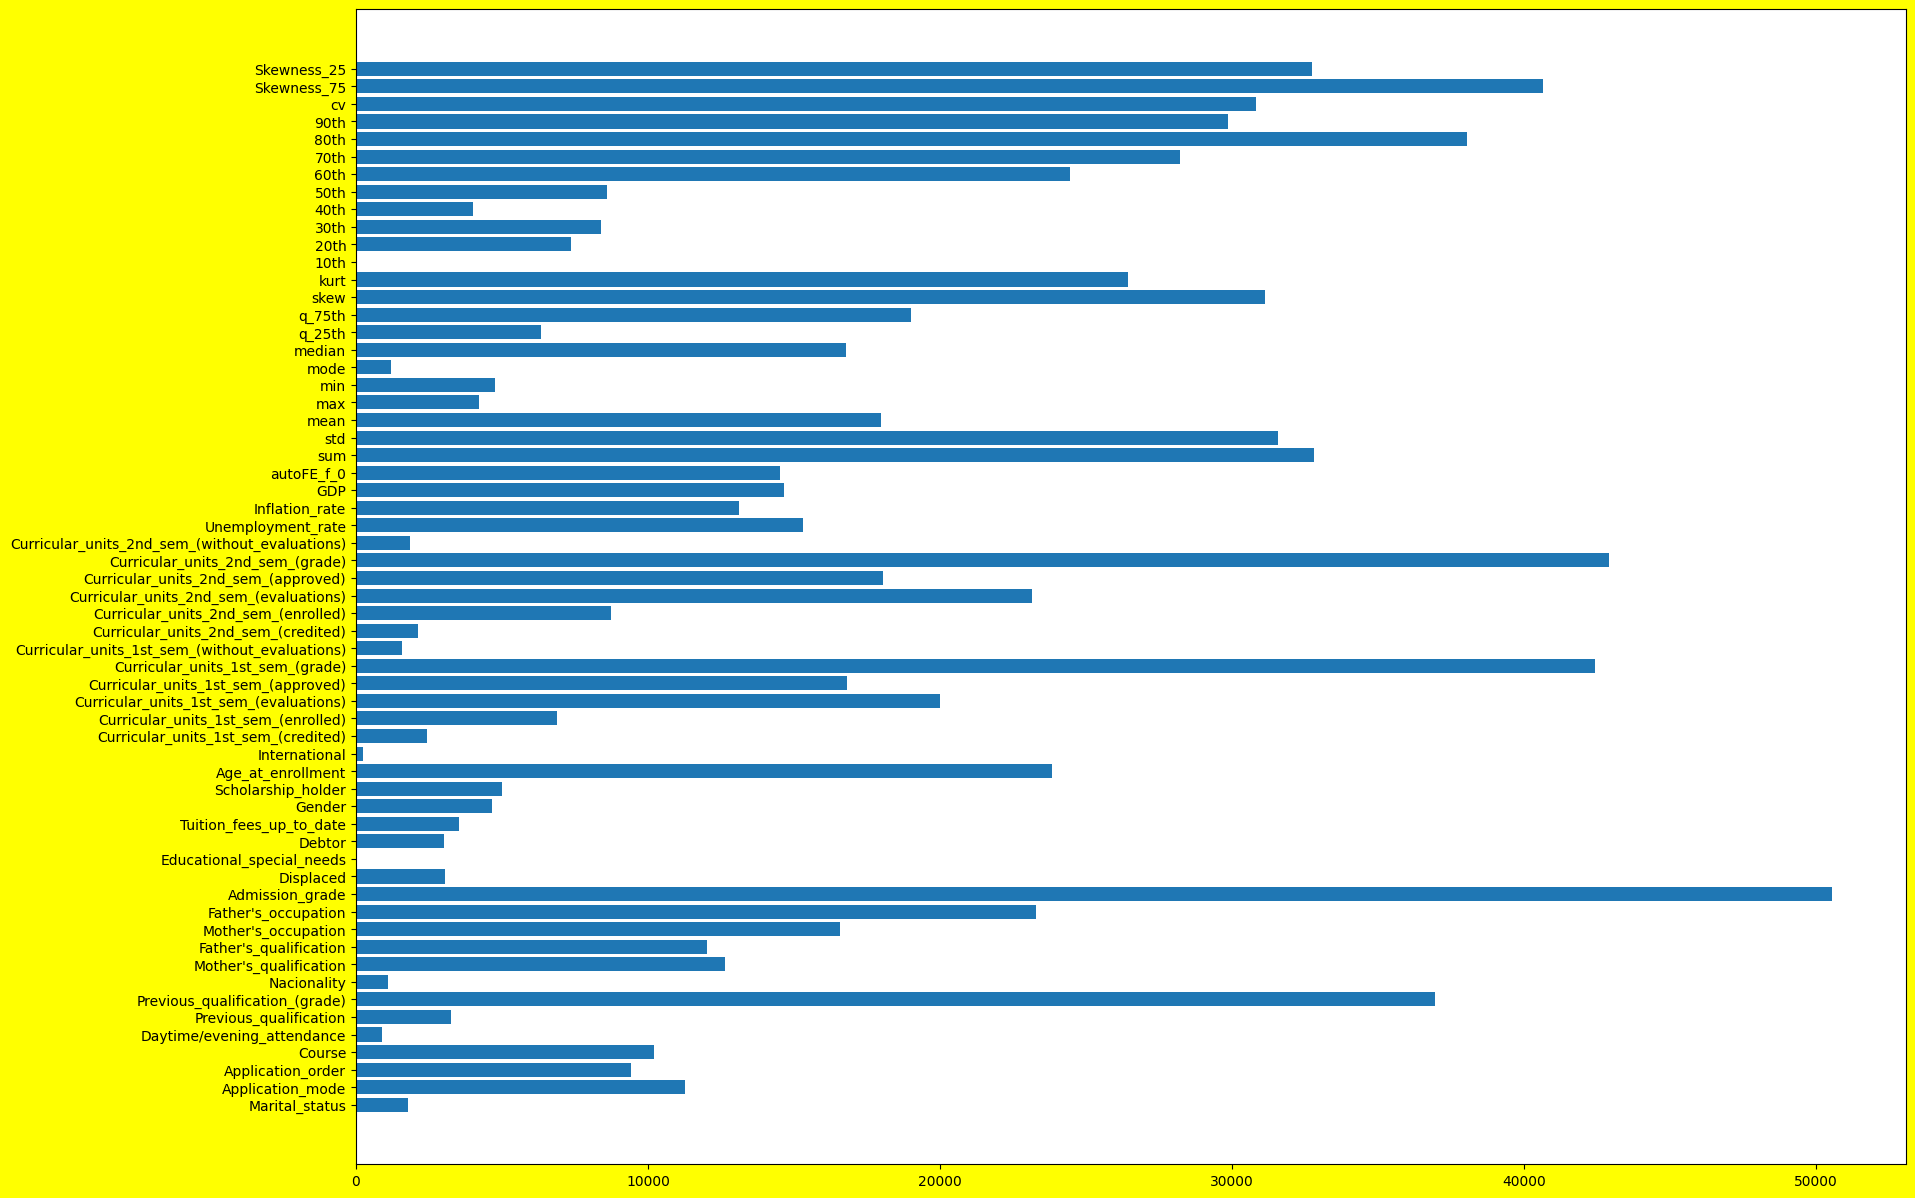

In [49]:
import  matplotlib.pyplot as plt
# Feature importance
plt.figure(figsize=((20,15)), facecolor='yellow')  # Set background color to yellow
plt.barh(
    automl2.model.estimator.feature_name_, automl2.model.estimator.feature_importances_
)
plt.show()